In [34]:
import os
import cv2
import PIL.Image as Image
import random
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
df_train = pd.read_csv('./data/train_labels.csv')

In [4]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## EDA

#### We need to check whether the labels are balanced. It's not a good idea to train on imbalanced dataset.

In [7]:
df_train['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

#### According to the number, it's not imbalanced. It's good enough for us.

In [10]:
malignant_images = df_train[df_train['label'] == 1].sample(n=10)

## Malignant

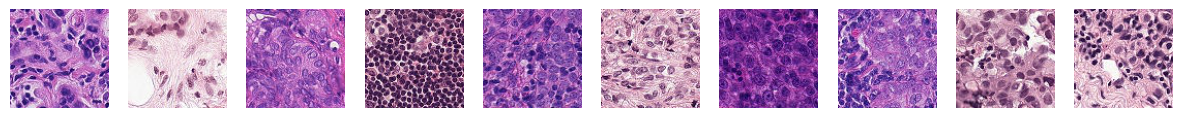

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 6))

for i, id in enumerate(malignant_images['id'].values):
    file = os.path.join('./data/train/', id + '.tif')
    # print(file)
    img = Image.open(file)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

## Non-Malignant

In [21]:
non_malignant_images = df_train[df_train['label'] == 0].sample(n=10)

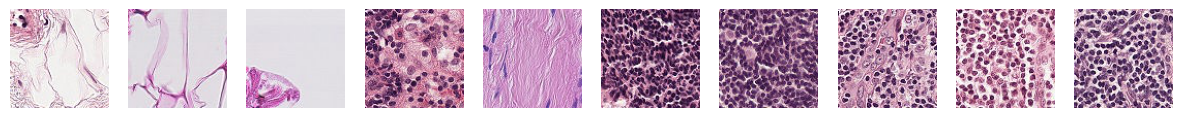

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 6))

for i, id in enumerate(non_malignant_images['id'].values):
    file = os.path.join('./data/train/', id + '.tif')
    img = Image.open(file)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

#### As a non pathologist, the data does not make any sense to me. That is why in practice, we need to work with domain experts. Still for the sake of exercise, I will continue to augment the data with common techniques.

## Data Augmentation

In [46]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset

In [47]:
class CNNDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None):
        self.data_dir = data_dir
        self.data = pd.read_csv(csv_file)
        self.classes = self.data.iloc[:, 1].unique()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.data.iloc[idx, 0]+'.tif')
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [48]:
dataset = CNNDataset(data_dir='./data/train/', csv_file='./data/train_labels.csv', transform=transform)

In [49]:
train_dataset_size = int(0.8 * len(dataset))
validation_dataset_size = len(dataset) - train_dataset_size
train_dataset, validation_dataset = random_split(dataset, [train_dataset_size, validation_dataset_size])

## Data Loader

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

## Model
I will use create a very simple convolutional neural network.

In [79]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 24 * 24, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [80]:
import torch.optim as optim

num_classes = 2
model = SimpleCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training Loop

In [83]:
from tqdm import tqdm

device = 'cuda'
model.to('cuda')

for epoch in range(5):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_dataloader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_loss /= len(train_dataloader)
    
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_accuracy = correct / total
    validation_loss /= len(validation_dataloader)
    
    print(f"Epoch [{epoch+1}/{5}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \
          Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


100%|██████████| 5501/5501 [05:41<00:00, 16.13it/s]


Epoch [1/5], Train Loss: 0.5049, Train Accuracy: 0.7588,           Validation Loss: 0.4722, Validation Accuracy: 0.7810


100%|██████████| 5501/5501 [05:06<00:00, 17.96it/s]


Epoch [2/5], Train Loss: 0.4622, Train Accuracy: 0.7862,           Validation Loss: 0.4494, Validation Accuracy: 0.7933


100%|██████████| 5501/5501 [05:13<00:00, 17.55it/s]


Epoch [3/5], Train Loss: 0.4480, Train Accuracy: 0.7935,           Validation Loss: 0.4333, Validation Accuracy: 0.8015


100%|██████████| 5501/5501 [05:22<00:00, 17.06it/s]


Epoch [4/5], Train Loss: 0.4345, Train Accuracy: 0.8007,           Validation Loss: 0.4264, Validation Accuracy: 0.8056


100%|██████████| 5501/5501 [05:08<00:00, 17.85it/s]


Epoch [5/5], Train Loss: 0.4225, Train Accuracy: 0.8072,           Validation Loss: 0.4179, Validation Accuracy: 0.8102


In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [106]:
predictions = []

for i in tqdm(list(df_train['id'].values)):
    img = Image.open('./data/train/' + i + '.tif')
    img = transform(img).unsqueeze(0)
    img = img.to('cuda')

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predictions.append(predicted.item())

100%|██████████| 220025/220025 [07:42<00:00, 475.60it/s]


## Result analysis

In [111]:
cm = confusion_matrix(list(df_train['label'].values), predictions)

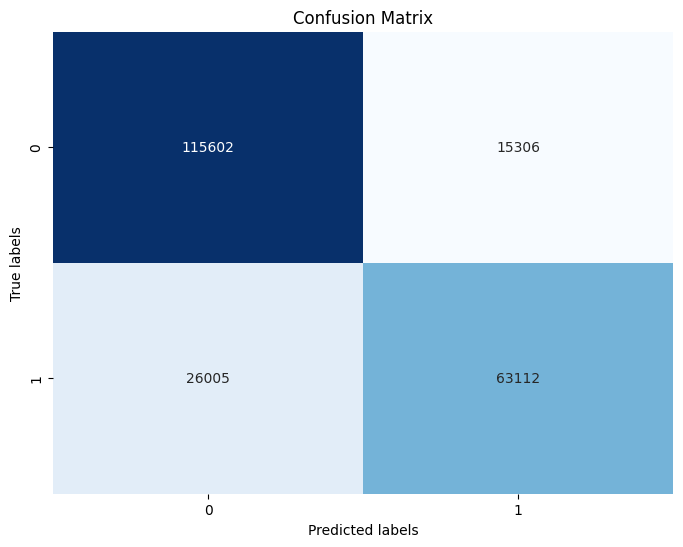

In [117]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

In [118]:
from sklearn.metrics import precision_recall_fscore_support

In [120]:
precision, recall, fscore, support = precision_recall_fscore_support(list(df_train['label'].values), predictions)
for label, p, r, f, s in zip(['Non-malignant', 'Malignant'], precision, recall, fscore, support):
    print(f"Class: {label}")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall: {r:.4f}")
    print(f"  F1-score: {f:.4f}")
    print(f"  Support: {s}\n")

Class: Non-malignant
  Precision: 0.8164
  Recall: 0.8831
  F1-score: 0.8484
  Support: 130908

Class: Malignant
  Precision: 0.8048
  Recall: 0.7082
  F1-score: 0.7534
  Support: 89117



## Submission

In [88]:
submission = {
    'id':[],
    'label':[]
}
for path in os.listdir('./data/test/'):
    img = Image.open('./data/test/' + path)
    img = transform(img).unsqueeze(0)
    img = img.to('cuda')

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    submission['id'].append(path.split('.')[0])
    submission['label'].append(predicted.item())

submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv', index=False)

## Transfer Learning

In [91]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

In [93]:
transfer_model = efficientnet_b2()
transfer_model.classifier[1] = nn.Linear(in_features=transfer_model.classifier[1].in_features, out_features=2)

In [94]:
transfer_model.to('cuda')

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [96]:
optimizer = optim.SGD(transfer_model.parameters(), lr=0.001, momentum=0.9)

In [97]:
for epoch in range(5):
    transfer_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_dataloader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = transfer_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_loss /= len(train_dataloader)
    
    transfer_model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = transfer_model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_accuracy = correct / total
    validation_loss /= len(validation_dataloader)
    
    print(f"Epoch [{epoch+1}/{5}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \
          Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████| 5501/5501 [04:42<00:00, 19.49it/s]


Epoch [1/5], Train Loss: 0.5189, Train Accuracy: 0.7513,           Validation Loss: 0.4710, Validation Accuracy: 0.7831


100%|██████████| 5501/5501 [04:40<00:00, 19.60it/s]


Epoch [2/5], Train Loss: 0.4497, Train Accuracy: 0.7967,           Validation Loss: 0.4183, Validation Accuracy: 0.8113


100%|██████████| 5501/5501 [04:39<00:00, 19.66it/s]


Epoch [3/5], Train Loss: 0.4230, Train Accuracy: 0.8096,           Validation Loss: 0.4002, Validation Accuracy: 0.8229


100%|██████████| 5501/5501 [04:39<00:00, 19.67it/s]


Epoch [4/5], Train Loss: 0.4026, Train Accuracy: 0.8201,           Validation Loss: 0.3708, Validation Accuracy: 0.8341


100%|██████████| 5501/5501 [04:39<00:00, 19.65it/s]


Epoch [5/5], Train Loss: 0.3881, Train Accuracy: 0.8279,           Validation Loss: 0.3574, Validation Accuracy: 0.8443


In [121]:
predictions_efficient = []

for i in tqdm(list(df_train['id'].values)):
    img = Image.open('./data/train/' + i + '.tif')
    img = transform(img).unsqueeze(0)
    img = img.to('cuda')

    with torch.no_grad():
        output = transfer_model(img)
        _, predicted = torch.max(output, 1)
        predictions_efficient.append(predicted.item())

100%|██████████| 220025/220025 [20:14<00:00, 181.17it/s]


## Result Analysis

In [122]:
cm = confusion_matrix(list(df_train['label'].values), predictions_efficient)

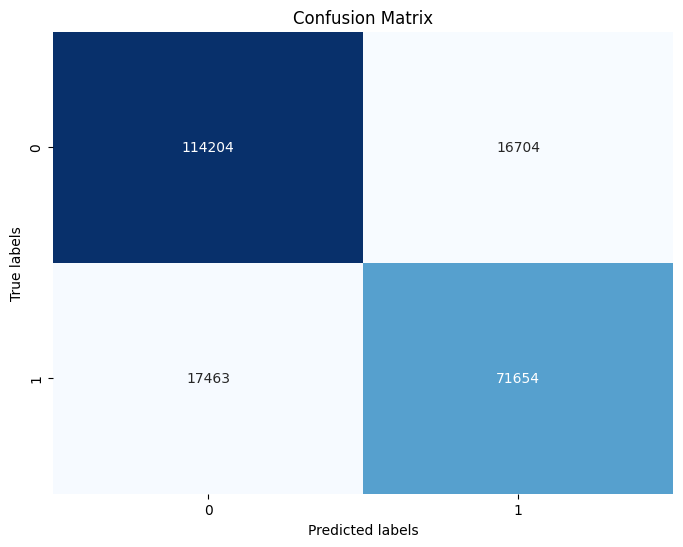

In [123]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

In [124]:
precision, recall, fscore, support = precision_recall_fscore_support(list(df_train['label'].values), predictions_efficient)
for label, p, r, f, s in zip(['Non-malignant', 'Malignant'], precision, recall, fscore, support):
    print(f"Class: {label}")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall: {r:.4f}")
    print(f"  F1-score: {f:.4f}")
    print(f"  Support: {s}\n")

Class: Non-malignant
  Precision: 0.8674
  Recall: 0.8724
  F1-score: 0.8699
  Support: 130908

Class: Malignant
  Precision: 0.8110
  Recall: 0.8040
  F1-score: 0.8075
  Support: 89117



In [98]:
submission = {
    'id':[],
    'label':[]
}
for path in tqdm(os.listdir('./data/test/')):
    img = Image.open('./data/test/' + path)
    img = transform(img).unsqueeze(0)
    img = img.to('cuda')

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    submission['id'].append(path.split('.')[0])
    submission['label'].append(predicted.item())

submission_df = pd.DataFrame(submission)
submission_df.to_csv('transfer_submission.csv', index=False)

100%|██████████| 57458/57458 [01:59<00:00, 481.26it/s]


## Conclusion
#### For the first experiment, I started it using a simple CNN. I got public score of 0.7988. So, I tried with transfer learning with EfficientNet and I got 0.8002. For the two experiments, I only trained for 5 epochs each due to limitation in compute. In the future, I will aim to train for about 20 epochs each depending on the loss curve. I will tune hyperparameters and run more experiments.

#### Although both models are not suitable for real world, I believe EffientNet is better suited because of high recall. In the real world, we want to minimize false negative. We want to make sure that we don't miss any cancerous cells.